# Smoothed lognormal density-split model vs. AbacusSummit dark matter simulations

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction

from densitysplit.corr_func_utils import get_poles, get_split_poles
from densitysplit.lognormal_model import *
from densitysplit import DensitySplit

# to automatically reload imported modules when executing cell
%load_ext autoreload
%autoreload 2

setup_logging()
    
plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

plots_dir = '/feynman/home/dphp/mp270220/plots/densitysplit'

2024-06-18 17:46:26.669642: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rhel-8.x86_64/gnu9/hdf5/1.10.8/lib:/opt/rhel-8.x86_64/modulefiles/gsl/26/lib:/datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2024-06-18 17:46:26.669685: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)


## Global parameters

In [2]:
# Mock parameters
cosmology=fiducial.AbacusSummitBase()
z = 0.8
nbar = 0.0034
nmocks = 25
rsd = False
if rsd:
    ells = [0, 2, 4]    
else:
    ells = [0]
nells = len(ells)

# Density smoothing parameters
cellsize = 10
cellsize2 = 10
resampler = 'tsc'

### Load DensitySplit

In [3]:
ds_dir = '/feynman/work/dphp/mp270220/outputs/densitysplit/'
simname = 'AbacusSummit_2Gpc_z{:.3f}_ph0{{:02d}}_downsampled_particles_nbar{:.4f}'.format(z, nbar)
cs2 = '_cellsize{:d}'.format(cellsize2) if cellsize2 is not None else ''
densityname = simname.format(0)+'_cellsize{:d}{}_resampler{}_delta_R{}'.format(cellsize, cs2, resampler, '_RSD' if rsd else '')

ds_fn = simname+'_cellsize{:d}{}_resampler{}_3splits_randoms_size4_RH_CCF{}'.format(cellsize, cs2, resampler, '_RSD' if rsd else '')
dsplit = [DensitySplit.load(os.path.join(ds_dir, ds_fn.format(i)+'.npy')) for i in range(nmocks)]
dsplit0 = dsplit[0]

## $\delta_R$

In [4]:
delta_R = dsplit0.readout_density(positions='randoms', resampler=resampler, seed=0)

[000023.49]  06-18 17:46  LognormalDensityModel        INFO     Initializing LognormalDensityModel
[000023.49]  06-18 17:46  LognormalDensityModel        INFO     Computing sigma, delta0 from the second and third order moments of the density sample.
[000024.78]  06-18 17:46  LognormalDensityModel        INFO     Seting sigma to 0.370, delta0 to 0.954.


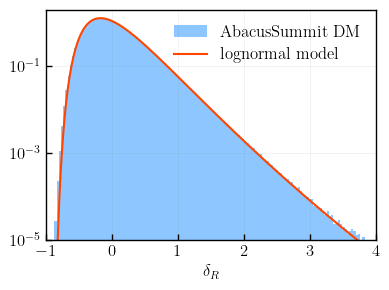

In [5]:
model = LognormalDensityModel()
delta = np.linspace(-1, 4, 200)
sigma, delta0 = model.get_params_from_moments(sample=delta_R)

plt.figure(figsize = (4, 3))
plt.hist(delta_R, bins=200, density=True, color='C0', alpha=0.5, label='AbacusSummit DM')
plt.plot(delta, model.density(delta), color='C1', label='lognormal model')
plt.xlabel(r'$\delta_R$')
plt.legend()
plt.xlim(-1, 4)
plt.yscale('log')
plt.ylim((1e-5, 2))
plt.savefig(os.path.join(plots_dir, densityname+'_lognormalmodel.pdf'), dpi=500)
plt.show()

if (cellsize2 is not None) & (cellsize2 != cellsize):
    delta_R2 = dsplit0.readout_density(positions='randoms', rsd=False, resampler=resampler, seed=0, mesh=2)
    sigma2, delta02 = model.get_params_from_moments(sample=delta_R2)

    plt.figure(figsize = (4, 3))
    plt.hist(delta_R2, bins=200, density=True, color='C0', alpha=0.5, label='AbacusSummit DM')
    plt.plot(delta, model.density(delta), color='C1', label='lognormal model')
    plt.xlabel(r'$\delta_R$')
    plt.legend()
    plt.xlim(-1, 4)
    plt.yscale('log')
    plt.ylim((1e-5, 2))
    densityname2 = simname.format(0)+'_cellsize{:d}{}_resampler{}_delta_R2{}'.format(cellsize, cs2, resampler, '_RSD' if rsd else '')
    plt.savefig(os.path.join(plots_dir, densityname2+'_lognormalmodel.pdf'), dpi=500)
    plt.show()

### Lognormal model for density splits

In [6]:
nsplits = 3

if rsd:
    bins = np.array([-1., -0.23633639, 0.10123832, np.inf])
else:
    bins = np.array([-1., -0.19435888, 0.09070214, np.inf])

densitysplitsmodel = LognormalDensitySplitModel(model, nsplits=nsplits, density_bins=bins)
densitysplitsmodel.set_params(sigma=sigma, delta0=delta0)

[000027.52]  06-18 17:46  LognormalDensityModel        INFO     Initializing LognormalDensitySplitsModel with 3 density splits
[000027.52]  06-18 17:46  LognormalDensityModel        INFO     Setting sigma to 0.370.
[000027.52]  06-18 17:46  LognormalDensityModel        INFO     Setting delta0 to 0.954.


In [7]:
densitysplitsmodel.set_smoothed_xi_model(redshift=z, cosmology=cosmology, boxsize=1000, nmesh=512, nbar=nbar, non_linear=True, smoothing_scale2=cellsize2)

[000027.55]  06-18 17:46  BaseTwoPointCorrelationFunctionModel INFO     Initializing BaseTwoPointCorrelationFunctionModel
[000027.55]  06-18 17:46  BaseTwoPointCorrelationFunctionModel INFO     Initializing theoretical 1D power spectrum
[000029.02]  06-18 17:46  BaseTwoPointCorrelationFunctionModel INFO     Initializing ParticleMesh with boxisze 1000, nmesh 512
[000029.02]  06-18 17:46  BaseTwoPointCorrelationFunctionModel INFO     Painting 1D power spectrum on 3D mesh


/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


[000044.77]  06-18 17:47  BaseTwoPointCorrelationFunctionModel INFO     3D power spectrum calculated in 15.74 seconds.
[000054.06]  06-18 17:47  BaseTwoPointCorrelationFunctionModel INFO     Initializing SmoothedTwoPointCorrelationFunctionModel
[000054.06]  06-18 17:47  BaseTwoPointCorrelationFunctionModel INFO     Setting smoothing scale to 10
[000054.06]  06-18 17:47  BaseTwoPointCorrelationFunctionModel INFO     Setting second smoothing scale to 10
[000054.06]  06-18 17:47  BaseTwoPointCorrelationFunctionModel INFO     Setting 3D smoothing kernel of order 6


/feynman/home/dphp/mp270220/densitysplit/densitysplit/base_model.py:144: RuntimeWarning: invalid value encountered in sqrt
  self.smoothed_sigma = np.sqrt(np.real(xiR))


[000074.50]  06-18 17:47  BaseTwoPointCorrelationFunctionModel INFO     Setting nbar to 0
[000091.52]  06-18 17:48  LognormalDensityModel        INFO     Adding shotnoise correction to the smoothed 2PCF.


## Smoothed 2PCF $\xi_{R}$

[000113.84]  06-18 17:48  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


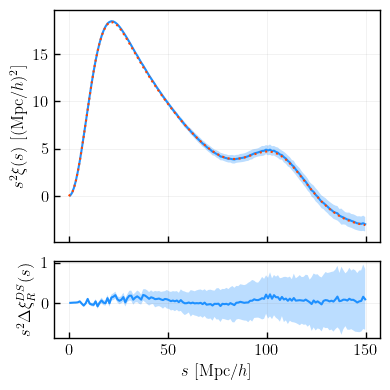

In [8]:
xi = [dsplit[i].smoothed_corr for i in range(nmocks)]
ximean, cov = get_poles(xi, ells=ells)
std = 0 if cov.size == 1 else np.diag(cov)**0.5
s, _ = xi[0].get_corr(ells=ells, return_sep=True)

xiname = simname.format(0)+'_cellsize{:d}{}_resampler{}_xi_R{}'.format(cellsize, cs2, resampler, '_RSD' if rsd else '')

if cellsize2 is None:
    smoothed_xi = densitysplitsmodel.smoothed_xi
else:
    smoothed_xi = densitysplitsmodel.double_smoothed_xi

fig, axes = plt.subplots(2, 1, figsize = (4, 4), sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})

for ill, ell in enumerate(ells):
    axes[0].plot(s, s**2 * ximean[ill], label='AbacusSummit DM', color='C0')
    if not rsd:
        axes[0].fill_between(s, s**2 * (ximean[ill] - std), s**2 * (ximean[ill] + std), facecolor='C0', alpha=0.3)
        axes[0].plot(densitysplitsmodel.sep, densitysplitsmodel.sep**2 * smoothed_xi, label=r'model', ls=':', color='C1')
        diff = ximean[ill] - smoothed_xi
        axes[1].plot(s, s**2 * diff, color='C0')
        axes[1].fill_between(s, s**2 * (diff - std), s**2 * (diff + std), facecolor='C0', alpha=0.3)

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1].set_ylabel(r'$s^2 \Delta \xi_{R}^{DS}(s)$')
axes[1].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.savefig(os.path.join(plots_dir, xiname+'.pdf'), dpi=500)
plt.show()

## Density splits

In [9]:
if rsd:
    xiR = np.mean(np.array([xi[i]() for i in range(nmocks)]), axis=0)
else:
    xiR = ximean.ravel()

In [10]:
mu_edges = xi[0].edges[1]
mu = (mu_edges[1:]+mu_edges[:-1])/2.
if rsd:
    xiR = xi[0]()
else:
    xiR = ximean.ravel()
densitysplits = densitysplitsmodel.compute_dsplits(delta02=delta02 if cellsize2 != cellsize else delta0, 
                                                   smoothing=2 if cellsize2 is not None else 1, 
                                                   xiR=xiR,
                                                   rsd=rsd, ells=ells,
                                                   sep=s, mu=mu)

[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Computing lognormal density split model.
[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Setting delta0 to 0.954.
[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Setting delta02 to 0.954.
[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Setting delta0 to 0.954.
[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Setting delta02 to 0.954.
[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Setting delta0 to 0.954.
[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Setting delta02 to 0.954.
[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Setting delta0 to 0.954.
[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Setting delta02 to 0.954.
[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Setting delta0 to 0.954.
[000114.43]  06-18 17:48  LognormalDensityModel        INFO     Setting delta02 to 0.954.


/feynman/home/dphp/mp270220/densitysplit/densitysplit/lognormal_model.py:250: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/self.delta0) + self.sigma**2/2. - np.log(1 + xiR/(self.delta0*self.delta02))) / (np.sqrt(2) * self.sigma))
/feynman/home/dphp/mp270220/densitysplit/densitysplit/lognormal_model.py:251: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/self.delta0) + self.sigma**2/2.) / (np.sqrt(2) * self.sigma))


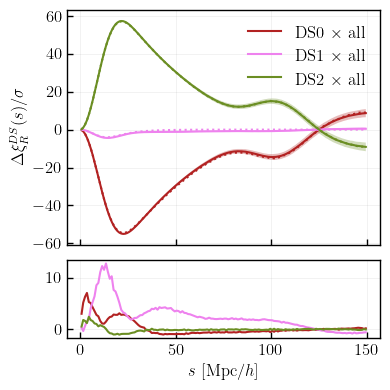

In [14]:
corr = [dsplit[i].ds_data_corr for i in range(nmocks)]
split_xi, cov = get_split_poles(corr, ells=ells, nsplits=nsplits)
std = np.zeros_like(split_xi) if cov.size == 1 else np.array_split(np.array(np.array_split(np.diag(cov)**0.5, nells)), nsplits, axis=1)
s, _, _ = corr[0][0].get_corr(return_sep=True)

xiname = simname.format(0)+'_cellsize{:d}{}_resampler{}_{}splits_randoms_size4_RH_CCF{}'.format(cellsize, cs2, resampler, nsplits, '_RSD' if rsd else '')

figsize = (8, 4) if rsd else (4, 4)
fig, axes = plt.subplots(2, nells, figsize=figsize, sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})
colors = ['firebrick', 'violet', 'olivedrab']

for ill, ell in enumerate(ells):
    ax0 = axes[0][ill] if nells > 1 else axes[0]
    ax1 = axes[1][ill] if nells > 1 else axes[1]
    
    for ds in range(nsplits):
        ax0.plot(s, s**2 * split_xi[ds][ill], color=colors[ds], label=r'DS{} $\times$ all'.format(ds))
        ax0.fill_between(s, s**2 * (split_xi[ds][ill] - std[ds][ill]), s**2 * (split_xi[ds][ill] + std[ds][ill]), facecolor=colors[ds], alpha=0.3)

        dsplitpole = densitysplits[ds][ill] if nells > 1 else densitysplits[ds]
        ax0.plot(densitysplitsmodel.sep, densitysplitsmodel.sep**2 * dsplitpole, ls=':', color=colors[ds])

        diff = dsplitpole.ravel() - split_xi[ds][ill]
        ax1.plot(s, s**2 * diff, color=colors[ds])
        ax1.fill_between(s, s**2 * (diff - std[ds][ill]), s**2 * (diff + std[ds][ill]), facecolor=colors[ds], alpha=0.3)
        #ax1.plot(s, diff/std[ds][ill], color=colors[ds])
    ax1.set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

ax0 = axes[0][0] if nells > 1 else axes[0]
ax0.set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax1 = axes[1][0] if nells > 1 else axes[0]
ax1.set_ylabel(r'$s^2 \Delta \xi_{R}^{DS}(s)$')
fig.align_ylabels()
ax0.legend()
plt.savefig(os.path.join(plots_dir, xiname+'_lognormalmodel.pdf'), dpi=500)
plt.show()